In [21]:
import cv2
from matplotlib import pyplot as plt
def display_images_with_labels(image_labels, layout, show_axis=True):
    """
    Hiển thị các ảnh cùng với nhãn bằng matplotlib.pyplot.

    Tham số:
    - image_labels: Danh sách các tuple (ảnh, nhãn) cần hiển thị.
    - layout: Tuple (rows, columns) chỉ định cách bố trí ảnh trên lưới.
    - show_axis: Bool, xác định xem có hiển thị trục hay không.
    """
    rows, columns = layout
    total_images = len(image_labels)

    # Tính số lượng ảnh cần thêm vào để điền đầy lưới
    num_padding = rows * columns - total_images

    # Thêm ảnh trống vào danh sách nếu cần
    image_labels += [(None, None)] * num_padding
    # điều chỉnh kích thước ảnh
    plt.figure(figsize=(10*columns, 10*rows))
    # Tạo subplot và hiển thị ảnh cùng với nhãn
    for i, (image, label) in enumerate(image_labels):
        plt.subplot(rows, columns, i + 1)
        if image is not None:
            # Chuyển đổi màu từ BGR sang RGB để hiển thị đúng
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            plt.imshow(image_rgb)
        if label is not None:
            plt.title(label)
        if not show_axis:
            plt.axis("off")
    plt.tight_layout()
    plt.show()

<Figure size 1000x2000 with 0 Axes>

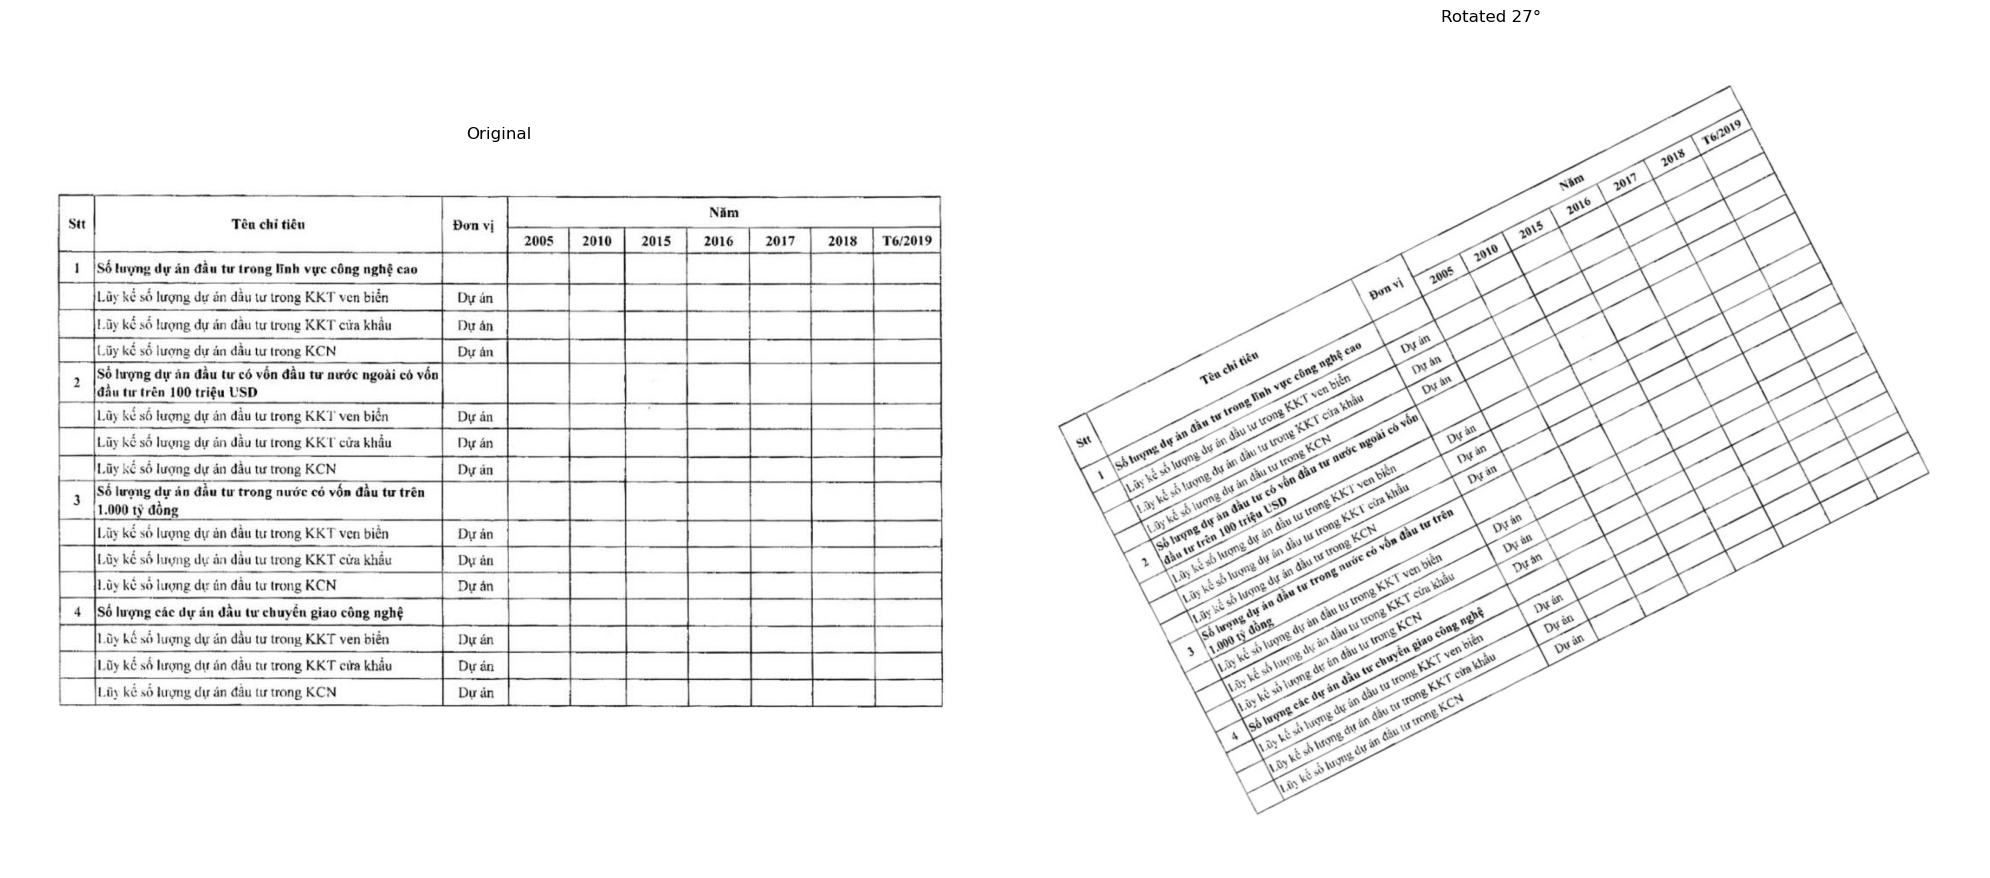

In [22]:
import cv2
import random
import numpy as np
from matplotlib import pyplot as plt

def rotate_image(image, angle):
    # Xác định kích thước ảnh
    height, width = image.shape[:2]

    # Tính toán ma trận xoay
    rotation_matrix = cv2.getRotationMatrix2D((width/2, height/2), angle, 1)
    
    # Tính toán kích thước mới của ảnh sau khi xoay
    cos = np.abs(rotation_matrix[0, 0])
    sin = np.abs(rotation_matrix[0, 1])
    new_width = int((height * sin) + (width * cos))
    new_height = int((height * cos) + (width * sin))
    
    # Cập nhật ma trận xoay để điều chỉnh kích thước ảnh
    rotation_matrix[0, 2] += (new_width / 2) - (width / 2)
    rotation_matrix[1, 2] += (new_height / 2) - (height / 2)
    
    # Thực hiện xoay và điều chỉnh kích thước ảnh
    rotated_image = cv2.warpAffine(image, rotation_matrix, (new_width, new_height), borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))
    return rotated_image

image = cv2.imread("sample/vn1.jpg")
angle = random.randint(-30, 30)
rotated_image = rotate_image(image, angle)
# thiết lập kích thước hiển thị ảnh
plt.figure(figsize=(10, 20))
# hiển thị ảnh gốc và ảnh đã xoay
display_images_with_labels([(image, "Original"), (rotated_image, f"Rotated {str(angle)}°")], (1, 2), show_axis=False)

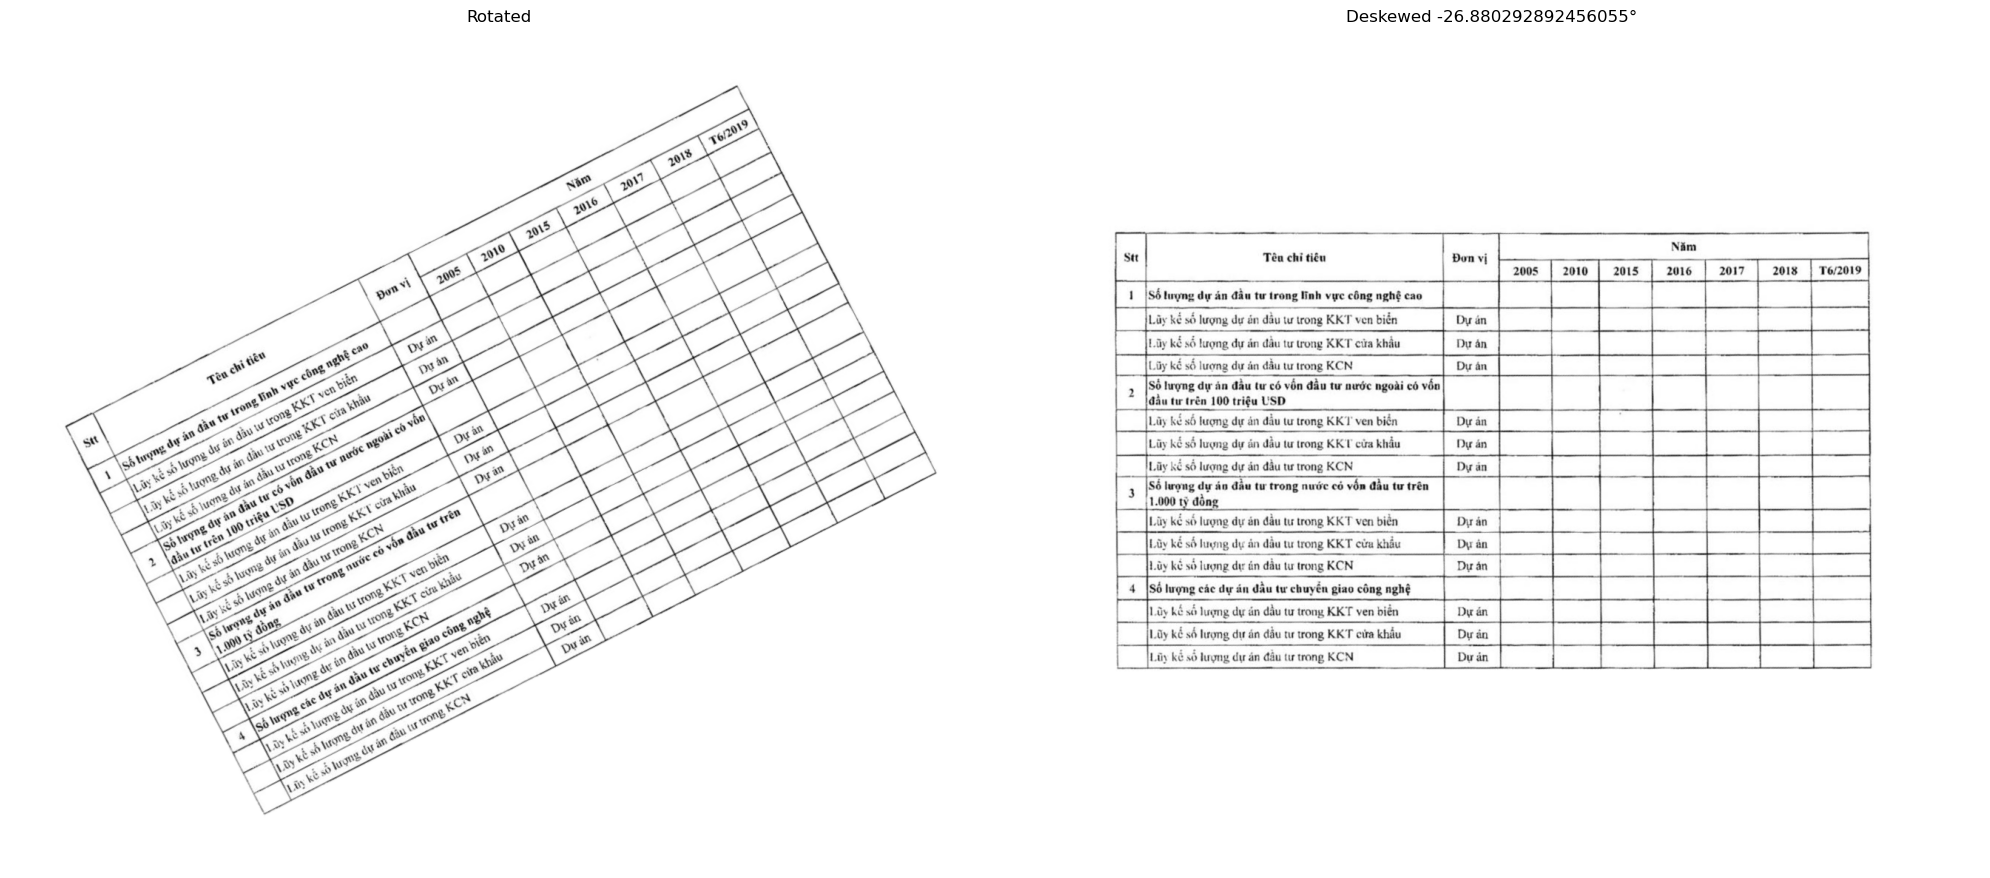

In [23]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

def deskew_image(image):
    # Làm mờ ảnh
    blur_image = cv2.medianBlur(image, 5)

    # Chuyển đổi sang ảnh grayscale
    grayscale_image = cv2.bitwise_not(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))

    # Xác định ngưỡng
    _, threshold_image = cv2.threshold(grayscale_image, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    # Tìm tọa độ các điểm ảnh khác 0
    coordinates = np.column_stack(np.where(threshold_image > 0))

    # Xác định góc xoay
    angle = cv2.minAreaRect(coordinates)[-1]
    if angle < -45:
        angle = -(90 + angle)
    elif angle > 45:
        angle = 90 - angle
    else:
        angle = -angle

    # Xoay ảnh để chỉnh sửa góc nghiêng
    height, width = blur_image.shape[:2]
    center = (width // 2, height // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    deskewed_image = cv2.warpAffine(image, rotation_matrix, (width, height), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

    return deskewed_image, angle

image_ok, calc_angle = deskew_image(rotated_image)
display_images_with_labels([(rotated_image, "Rotated"), (image_ok, f"Deskewed {str(calc_angle)}°")], (1, 2), show_axis=False)

In [24]:
def detect_lines(img_bin, fixkernel, detectkernel):
    image_0 = cv2.dilate(img_bin, fixkernel, iterations=2)
    image_1 = cv2.erode(image_0, detectkernel, iterations=3)
    result = cv2.dilate(image_1, detectkernel, iterations=4)    
    return result

def recognize_structure(img):
    outImag=[]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_height, img_width = img.shape
    # THRESH_OTSU là phương pháp tự động xác định ngưỡng dựa trên histogram của ảnh
    thresh, img_bin = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU) 
    outImag.append((img_bin, 'invert'))

    # Giả sử bảng có tối đa 50 dòng và 50 cột
    kernel_len_ver = img_height // 50
    kernel_len_hor = img_width // 50
    # Defining a vertical kernel to detect all vertical lines of image
    ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len_ver)) 

    # Defining a horizontal kernel to detect all horizontal lines of image
    hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len_hor, 1))  

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
 
    vertical_lines = detect_lines(img_bin, kernel, ver_kernel)
    outImag.append((vertical_lines, 'vertical_lines'))
    
    horizontal_lines = detect_lines(img_bin, kernel, hor_kernel)
    outImag.append((horizontal_lines, 'horizontal_lines'))

    img_vh = cv2.bitwise_or(vertical_lines, horizontal_lines)
    outImag.append((img_vh, 'Combine'))
    
    img_vh = cv2.dilate(img_vh, kernel, iterations=1)
    outImag.append((img_vh, 'dilate'))

    img_sub = cv2.bitwise_and(vertical_lines, horizontal_lines)
    outImag.append((img_sub, 'subtraction'))

    return img_vh, img_sub, outImag

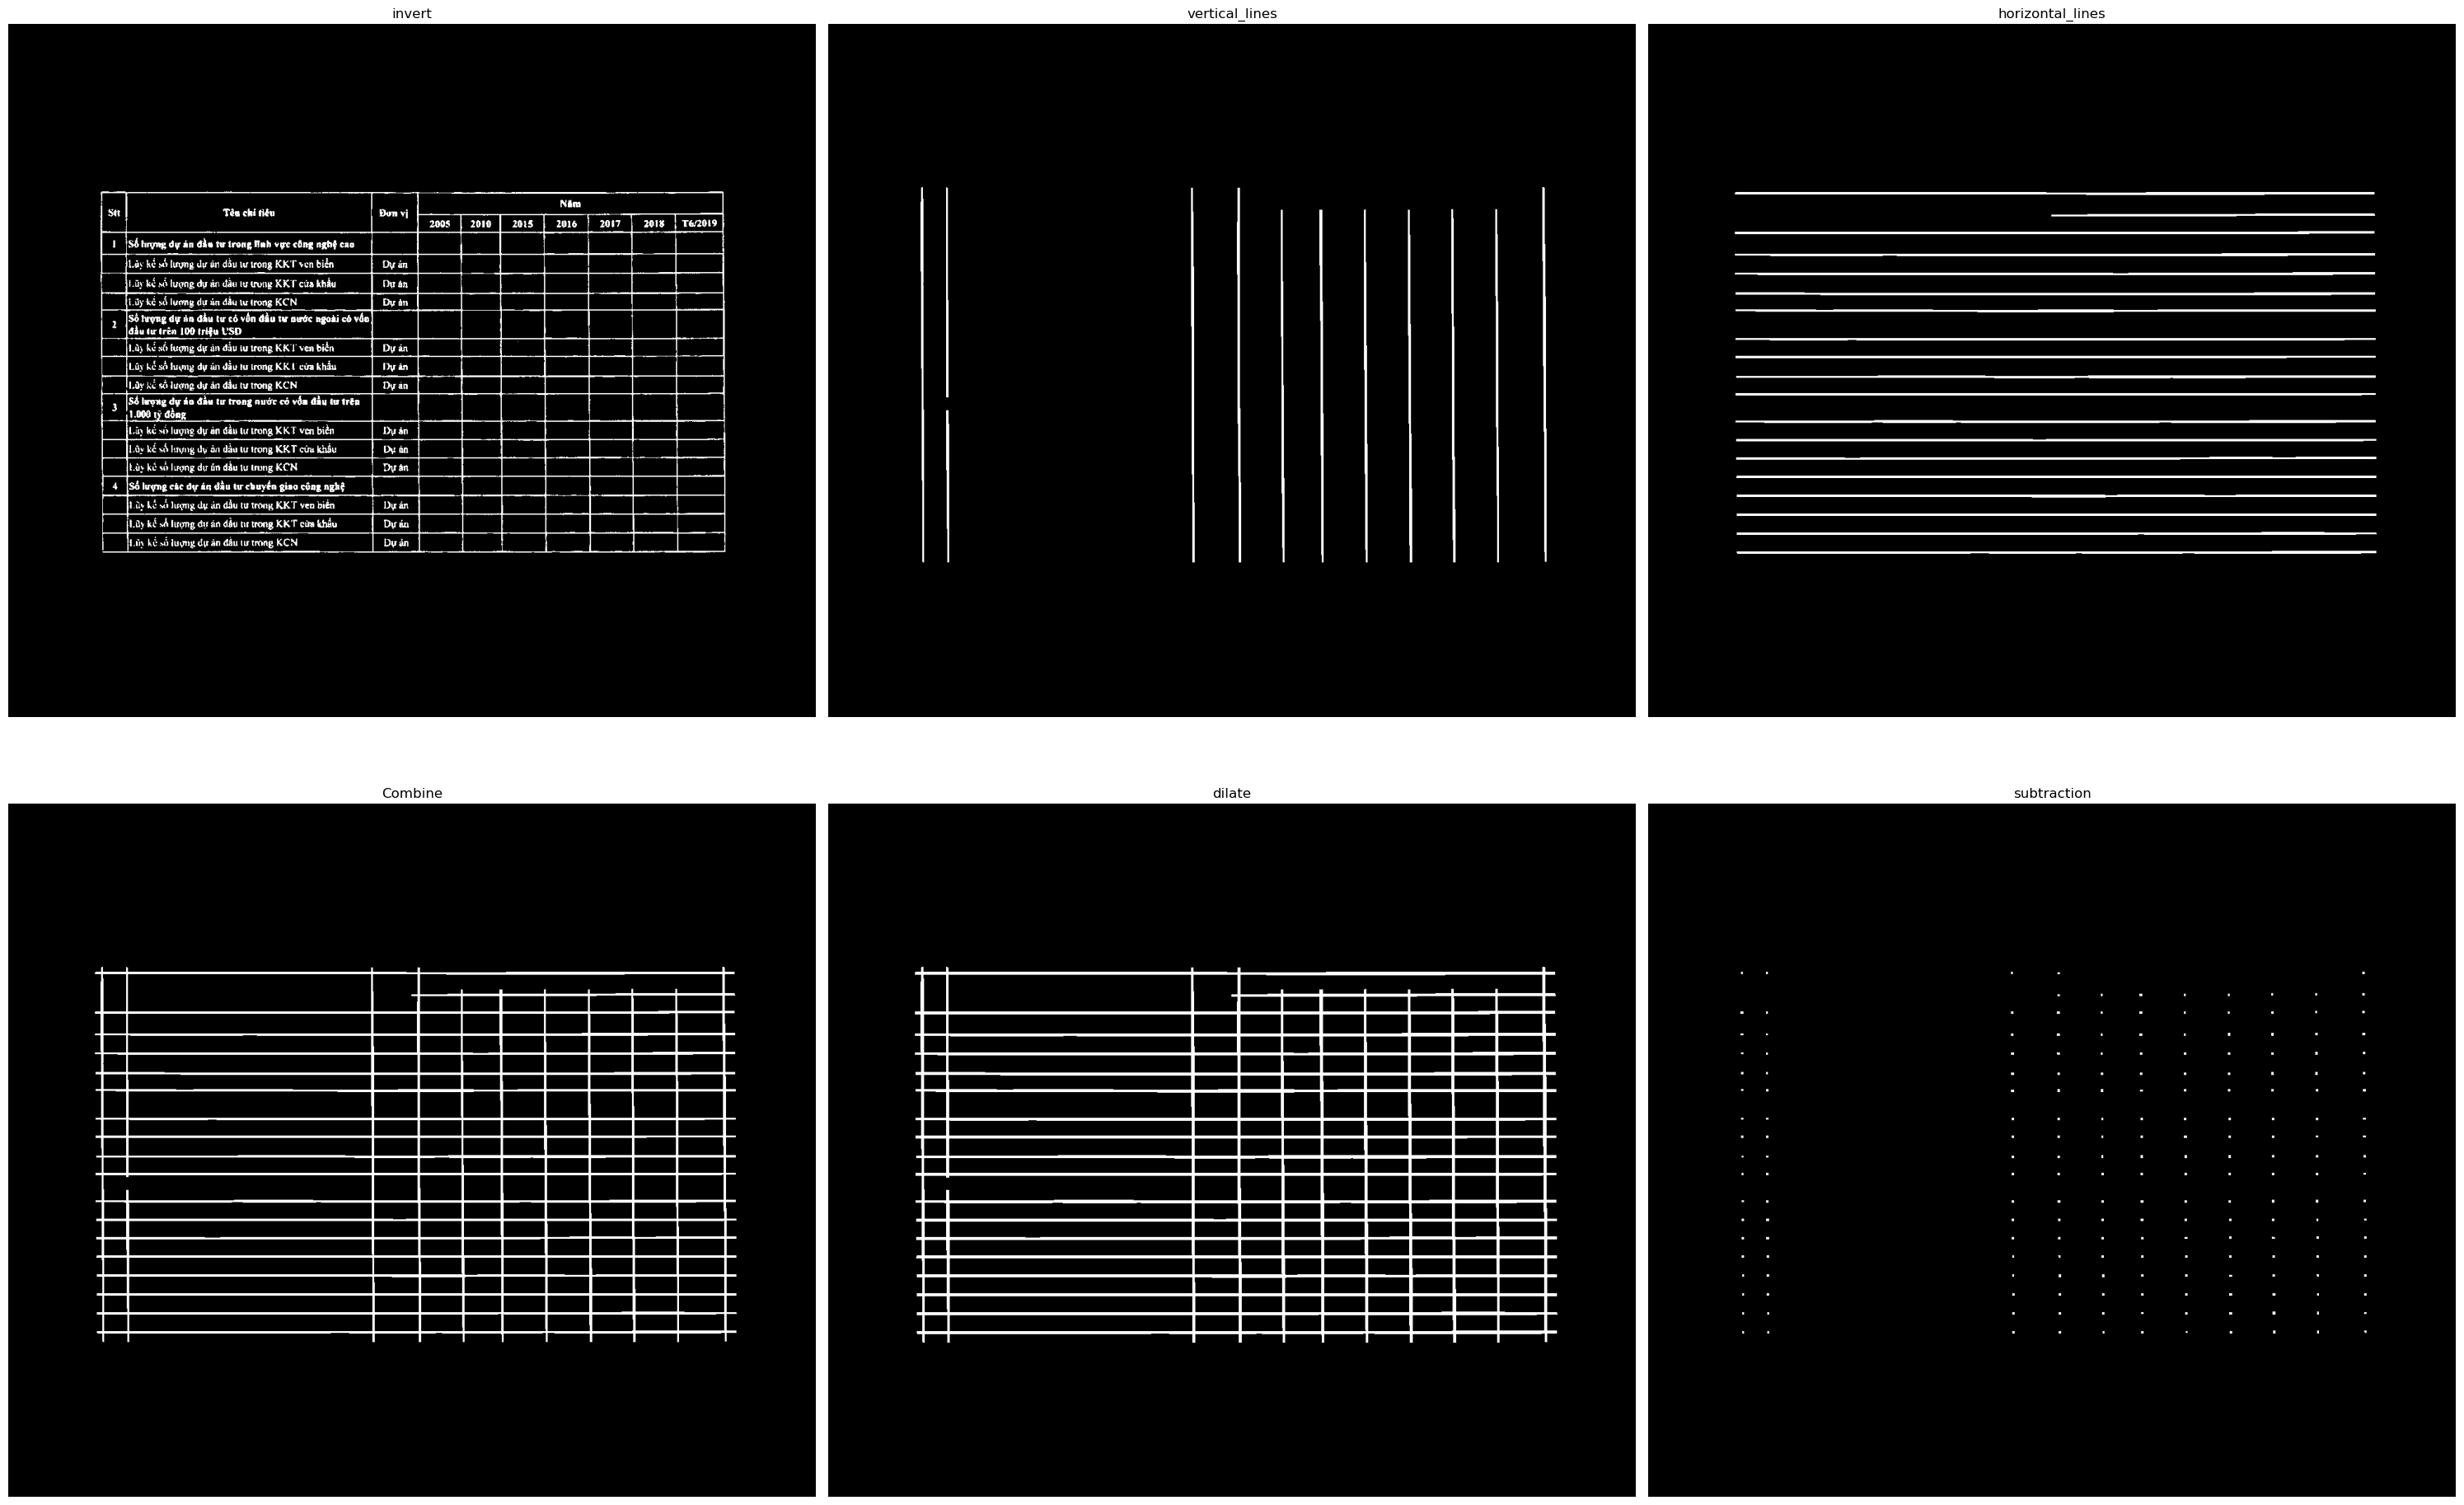

In [25]:
mask, dots, outImag = recognize_structure(image_ok)
num_cols = 3
num_rows = len(outImag) // num_cols if len(outImag) % num_cols == 0 else len(outImag) // num_cols + 1
display_images_with_labels(outImag, (num_rows, num_cols), show_axis=False)

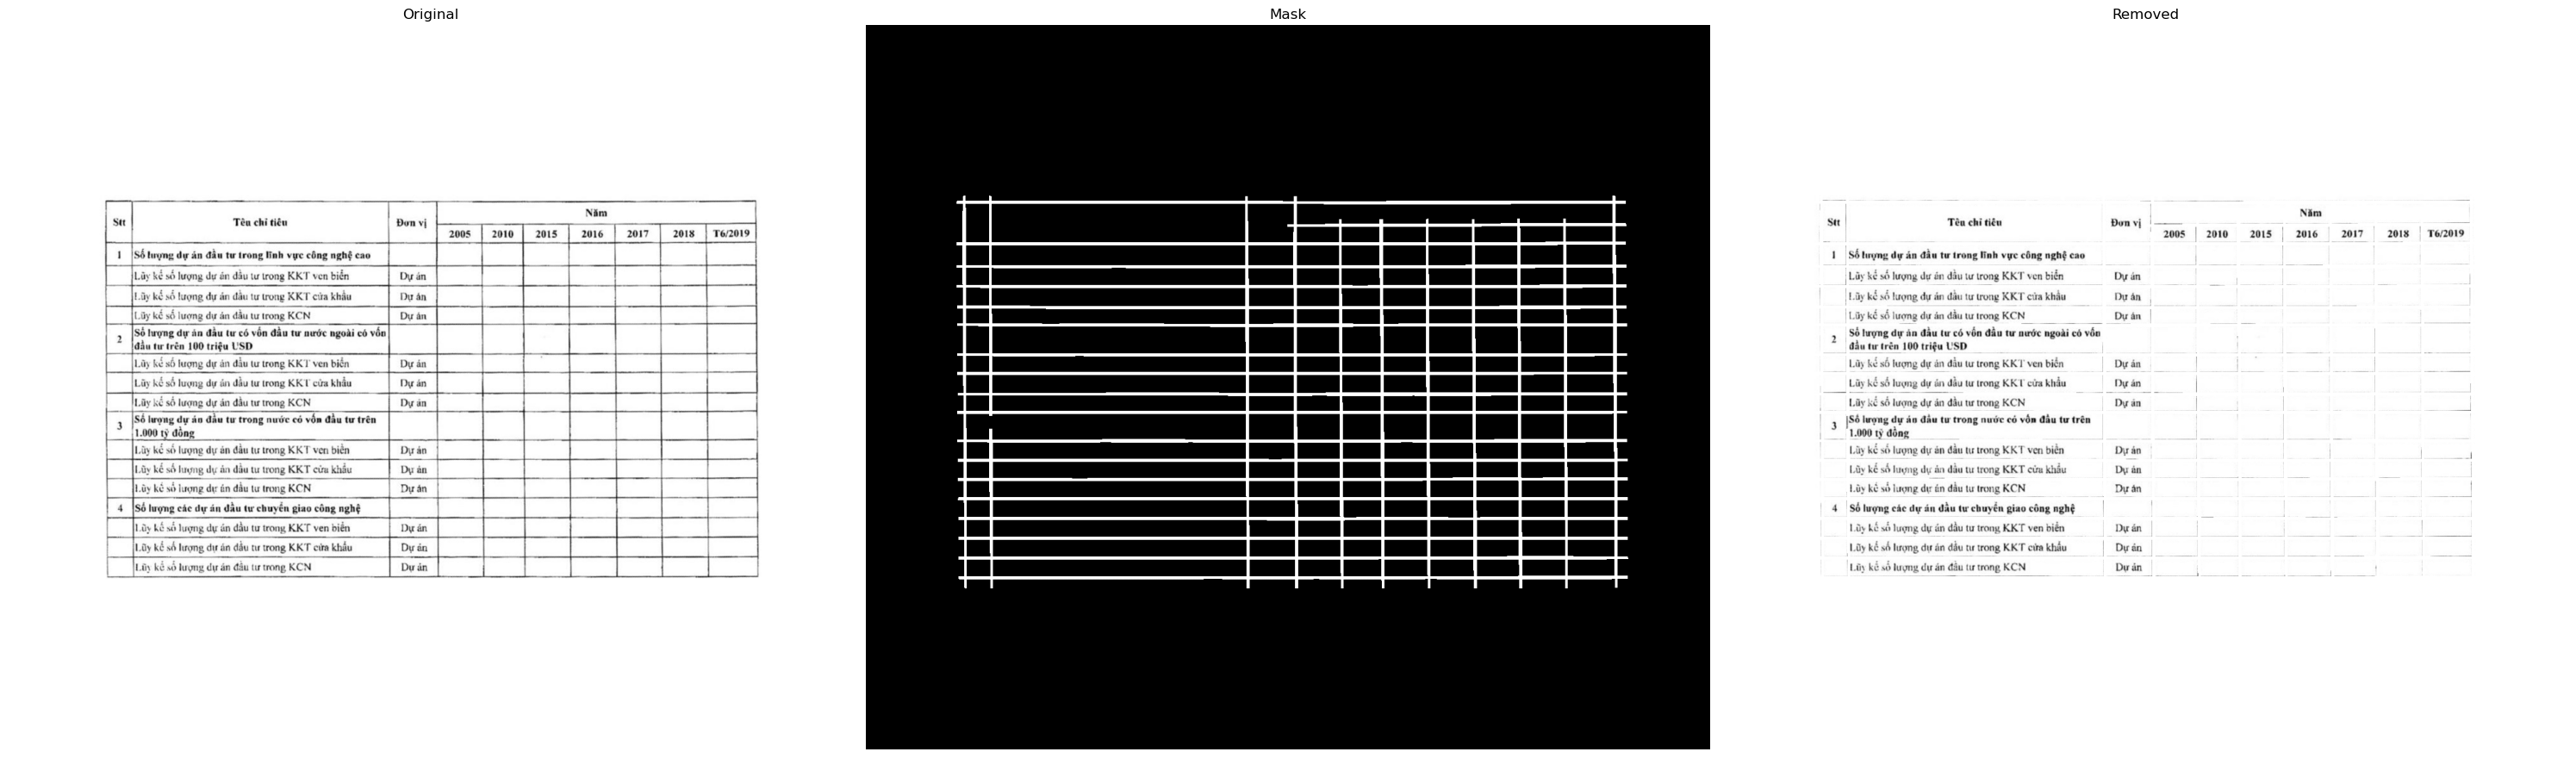

In [26]:
import cv2
import numpy as np

def remove_regions(image, mask):
    """
    Loại bỏ các vùng trong ảnh sử dụng mặt nạ.

    Tham số:
    - image: Ảnh gốc.
    - mask: Mặt nạ có kích thước giống với ảnh, với giá trị 0 ở các vùng cần loại bỏ và 1 ở các vùng khác.

    Trả về:
    - Ảnh đã loại bỏ các vùng cần loại bỏ.
    """
    masked_image = image.copy()
    masked_image[mask != 0] = [255, 255, 255]
    return masked_image

image_removed = remove_regions(image_ok, mask)
display_images_with_labels([(image_ok, "Original"), (mask,'Mask'), (image_removed, "Removed")], (1, 3), show_axis=False)

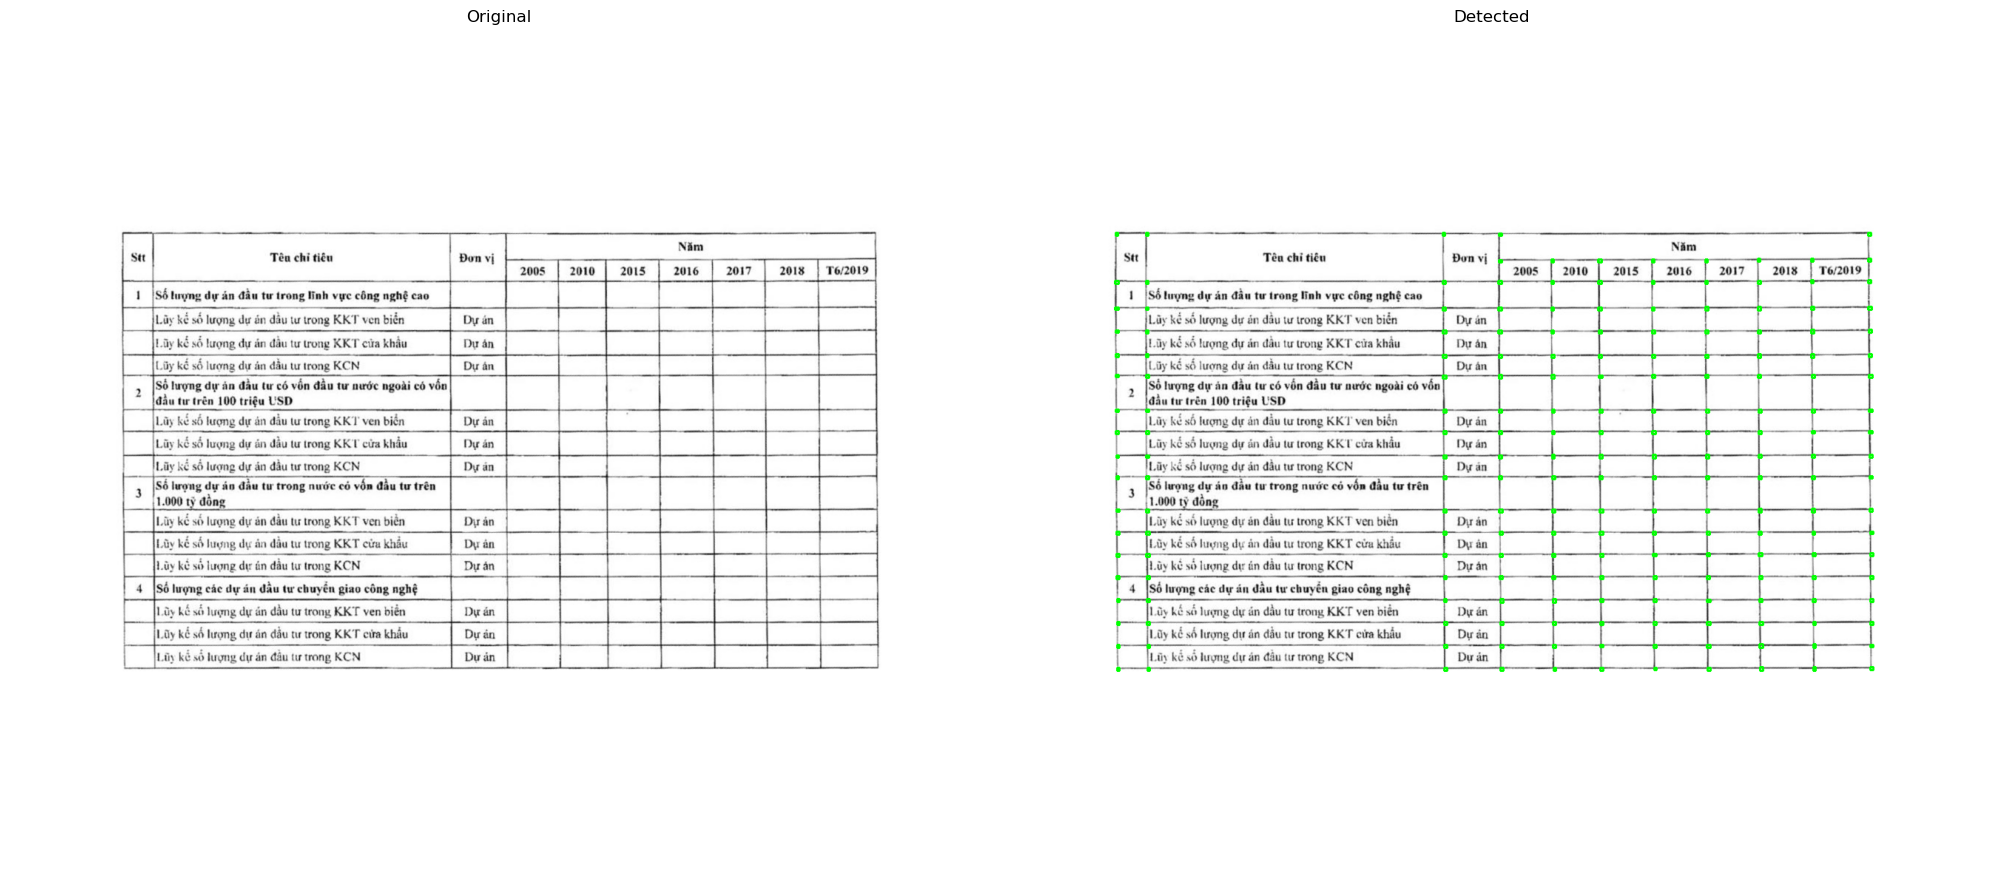

In [27]:
import cv2
import numpy as np

def detect_boxes(img_bin, image):
    """
    Phát hiện các ô trong ảnh nhị phân.

    Tham số:
    - img_bin: Ảnh nhị phân chứa mặt nạ các ô.
    - image: Ảnh gốc.

    Trả về:
    - Danh sách các ô đã phát hiện được. Mỗi ô là một list gồm 4 phần tử [x, y, w, h] tương ứng với tọa độ góc trên bên trái và kích thước của ô.
    """

    # Detect contours
    contours, hierarchy = cv2.findContours(img_bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Sort contours from top to bottom
    def sort_contours(cnts, method="top-to-bottom"):
        reverse = False
        i = 0

        if method == "right-to-left" or method == "bottom-to-top":
            reverse = True

        if method == "top-to-bottom" or method == "bottom-to-top":
            i = 1

        boundingBoxes = [cv2.boundingRect(c) for c in cnts]
        cnts, boundingBoxes = zip(*sorted(zip(cnts, boundingBoxes), key=lambda b: b[1][i], reverse=reverse))

        return cnts, boundingBoxes

    contours, boundingBoxes = sort_contours(contours, method="top-to-bottom")

    # Calculate mean height of boxes
    heights = [boundingBoxes[i][3] for i in range(len(boundingBoxes))]
    mean_height = np.mean(heights)

    # Create list to store boxes
    box = []

    # Filter and draw boxes
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        if w < 0.9 * image.shape[1] and h < 0.9 * image.shape[0]:
            image = cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
            box.append([x, y, w, h])

    # Sort boxes to rows and columns
    row = []
    column = []
    previous = box[0]

    for i, bbox in enumerate(box[1:]):
        if bbox[1] <= previous[1] + mean_height / 2:
            column.append(bbox)
            previous = bbox

            if i == len(box) - 2:
                row.append(column)
        else:
            row.append(column)
            column = []
            previous = bbox
            column.append(bbox)

    # Calculate maximum number of cells
    countcol = max(len(r) for r in row)

    # Retrieve the center of each column
    center = [int(r[j][0] + r[j][2] / 2) for r in row for j in range(len(r))]

    # Sort the boxes based on the distance to the column center
    finalboxes = []
    # for r in row:
    #     lis = [[] for _ in range(countcol)]
    #     for bbox in r:
    #         diff = abs(center - (bbox[0] + bbox[2] / 4))
    #         minimum = min(diff)
    #         indexing = list(diff).index(minimum)
    #         lis[indexing].append(bbox)
    #     finalboxes.append(lis)

    return finalboxes, image

boxes, draw_img = detect_boxes(outImag[-1][0], image_ok.copy())
display_images_with_labels([(image_ok, "Original"), (draw_img, "Detected")], (1, 2), show_axis=False)

[(954, 865), (881, 864), (809, 865), (745, 865), (674, 865), (598, 865), (196, 865), (155, 865), (1174, 864), (1096, 864), (1025, 864), (1174, 833), (953, 834), (881, 834), (809, 833), (745, 834), (674, 834), (598, 834), (196, 834), (155, 834), (1096, 833), (1024, 833), (1174, 803), (1096, 803), (1024, 803), (953, 803), (881, 803), (809, 803), (745, 803), (674, 803), (598, 803), (196, 803), (155, 803), (953, 772), (1174, 772), (1096, 772), (1024, 772), (881, 772), (809, 772), (745, 772), (674, 772), (597, 772), (196, 772), (155, 772), (1174, 741), (1096, 741), (1024, 741), (953, 741), (881, 741), (809, 741), (744, 741), (673, 741), (597, 741), (196, 741), (155, 741), (880, 710), (809, 711), (744, 711), (673, 711), (597, 711), (195, 711), (155, 711), (1174, 710), (1096, 710), (1023, 710), (953, 710), (1174, 680), (1095, 681), (1023, 681), (953, 681), (880, 681), (808, 681), (744, 681), (673, 681), (597, 681), (195, 681), (155, 681), (952, 651), (880, 651), (808, 651), (744, 651), (672, 

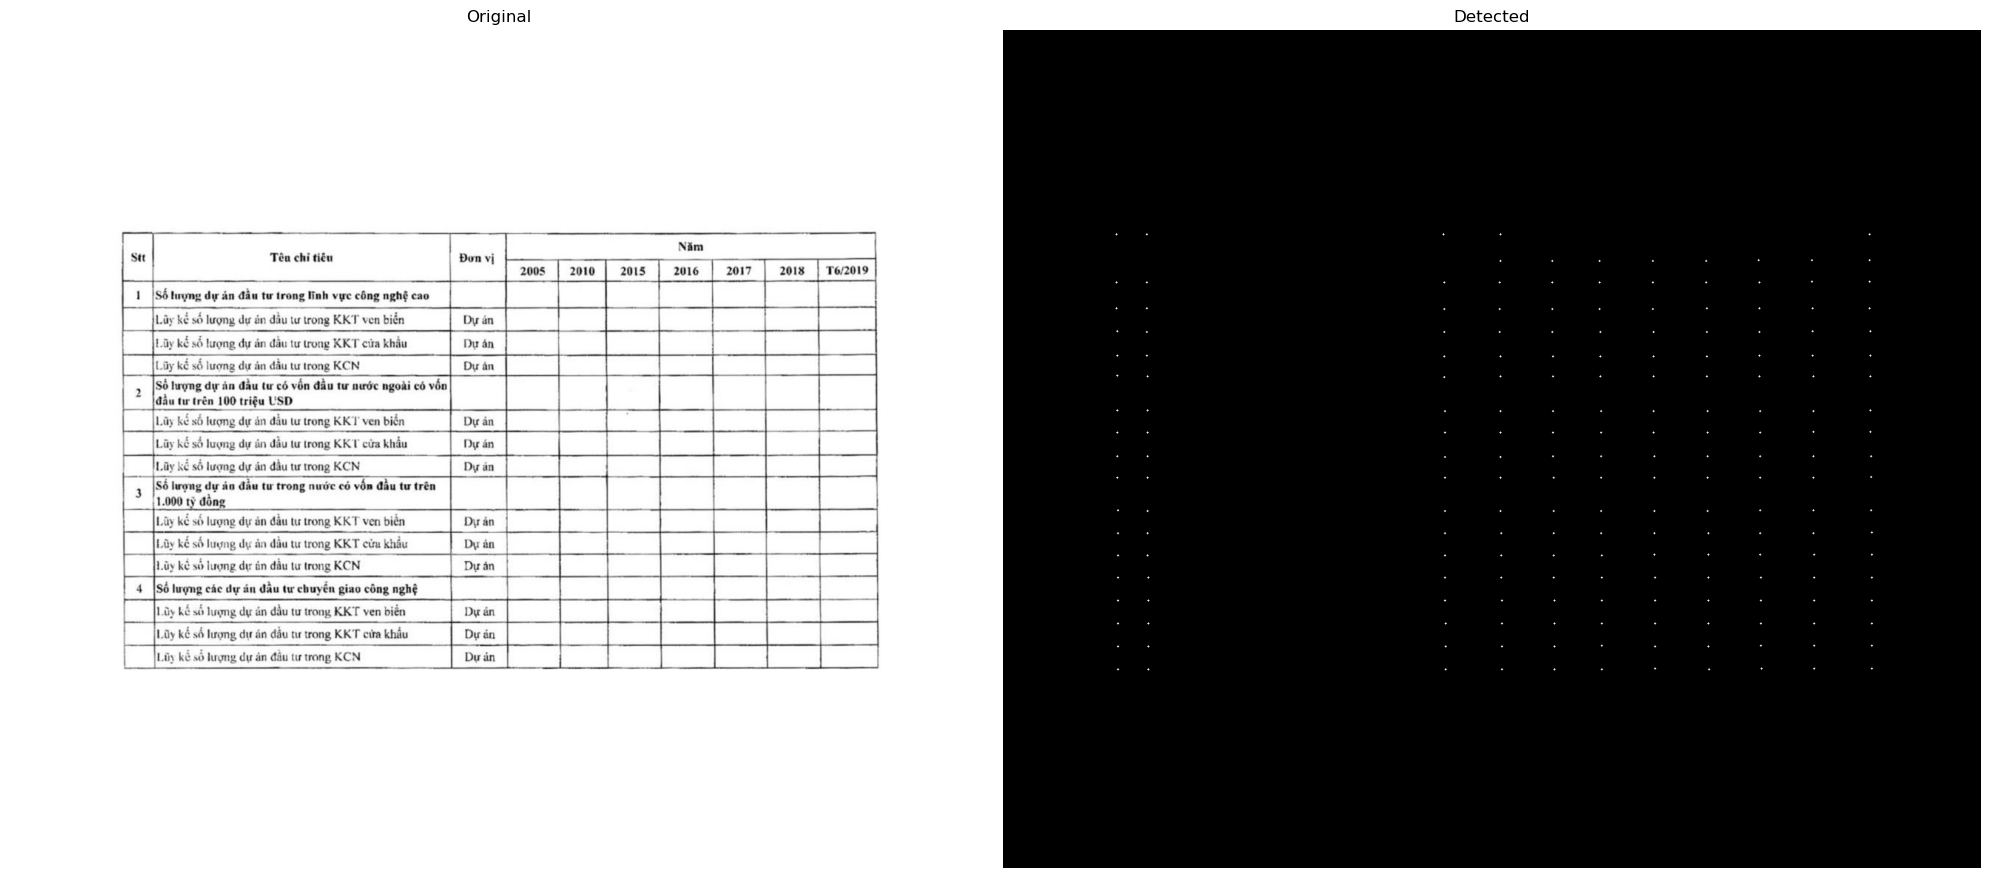

In [28]:
# có có img_bin, thực hiện bồi đắp theo kernel 3x3, sao đó tìm bbox, trả về trọng tâm của bbox
def findCenters(img_bin):
    kernel = np.ones((3,3),np.uint8)
    img_bin = cv2.dilate(img_bin, kernel, iterations=1)
    contours, hierarchy = cv2.findContours(img_bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    centers = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        centers.append((x + w // 2, y + h // 2))
    return centers

centers = findCenters(dots)
print(centers)
# tạo 1 img mới, với kích thước bằng kích thước của img gốc, màu đen
# vẽ các trọng tâm của bbox lên img mới
def drawCenters(img, centers):
    img = np.zeros_like(img)
    for center in centers:
        cv2.circle(img, center, 1, (255, 255, 255), -1)
    return img

dots_img = drawCenters(image_ok, centers)
display_images_with_labels([(image_ok, "Original"), (dots_img, "Detected")], (1, 2), show_axis=False)

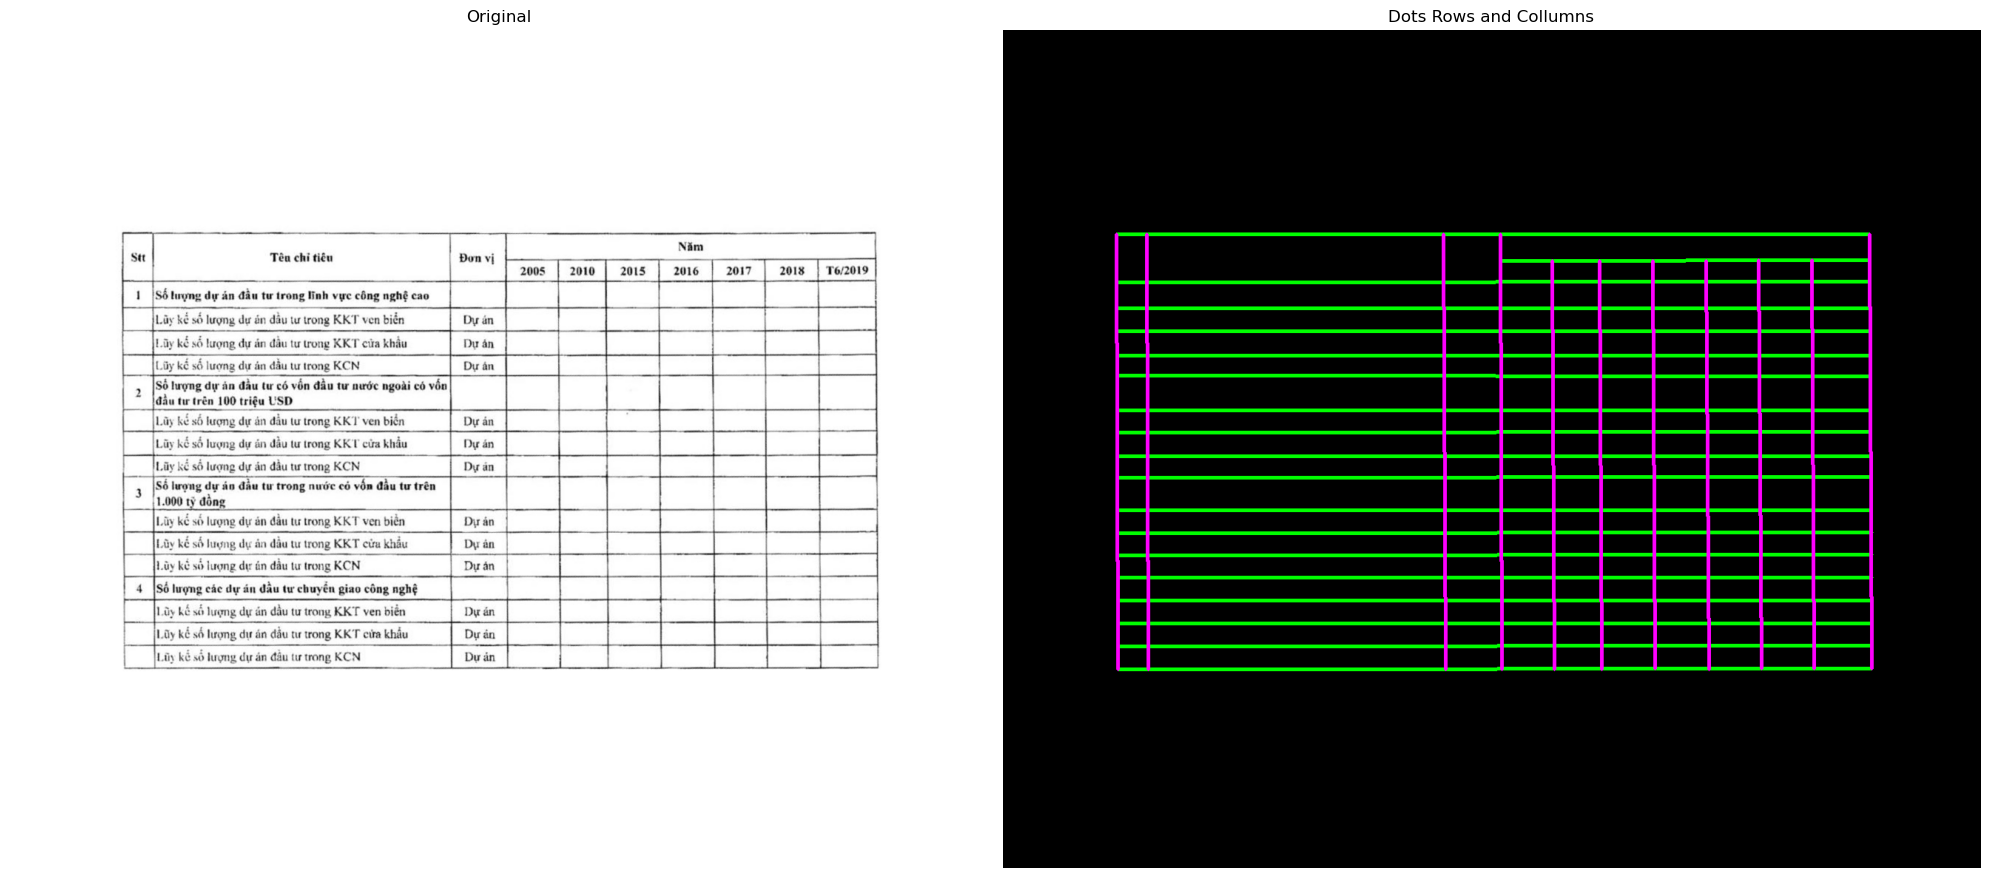

In [29]:
def split_rows_columns(centers, mode='row'):
    mode = 0 if mode == 'row' else 1
    centers.sort(key=lambda c: c[1-mode])  # Sắp xếp centers theo tọa độ y hoặc x tùy theo mode
    rows_columns = []
    current_row_column = [centers[0]]
    for center in centers[1:]:
        if abs(center[1-mode] - current_row_column[0][1-mode]) <= 10:  # Điểm y hoặc x gần nhau thuộc cùng một hàng hoặc cột
            current_row_column.append(center)
        else:  # Điểm y hoặc x xa, tạo hàng hoặc cột mới
            rows_columns.append(current_row_column)
            current_row_column = [center]
    rows_columns.append(current_row_column)  # Thêm hàng/cột cuối cùng
    # Sắp xếp lại các center trong mỗi hàng/cột theo tọa độ x hoặc y tùy theo mode
    for row_column in rows_columns:
        row_column.sort(key=lambda c: c[mode])
    return rows_columns

rows = split_rows_columns(centers, mode='row')

columns = split_rows_columns(centers, mode='column')

# Vẽ các hàng và cột lên ảnh
def draw_rows_columns(img, rows, columns):
    img = img.copy()
    for row in rows:
        cv2.line(img, row[0], row[-1], (0, 255, 0), 3)
    for column in columns:
        cv2.line(img, column[0], column[-1], (255, 0, 255), 3)
    return img

rows_collums_img = draw_rows_columns(dots_img, rows, columns)
display_images_with_labels([(image_ok, "Original"), (rows_collums_img, "Dots Rows and Collumns")], (1, 2), show_axis=False)

In [30]:
rows


[[(153, 277), (194, 277), (595, 277), (672, 277), (1171, 277)],
 [(672, 313),
  (742, 313),
  (806, 313),
  (878, 313),
  (950, 313),
  (1021, 312),
  (1093, 312),
  (1171, 312)],
 [(153, 342),
  (194, 342),
  (596, 342),
  (671, 342),
  (742, 342),
  (806, 342),
  (878, 342),
  (950, 342),
  (1022, 342),
  (1093, 341),
  (1171, 341)],
 [(153, 377),
  (194, 377),
  (596, 378),
  (671, 378),
  (742, 378),
  (806, 378),
  (878, 378),
  (951, 377),
  (1022, 377),
  (1094, 377),
  (1171, 377)],
 [(154, 408),
  (194, 409),
  (596, 409),
  (671, 409),
  (742, 409),
  (807, 409),
  (879, 409),
  (951, 409),
  (1022, 409),
  (1094, 408),
  (1172, 408)],
 [(154, 441),
  (194, 441),
  (596, 442),
  (672, 442),
  (743, 442),
  (807, 442),
  (879, 442),
  (951, 442),
  (1022, 441),
  (1094, 441),
  (1172, 441)],
 [(154, 468),
  (195, 469),
  (596, 470),
  (672, 469),
  (743, 469),
  (807, 469),
  (879, 469),
  (951, 469),
  (1022, 469),
  (1095, 469),
  (1172, 469)],
 [(154, 515),
  (195, 515),
  

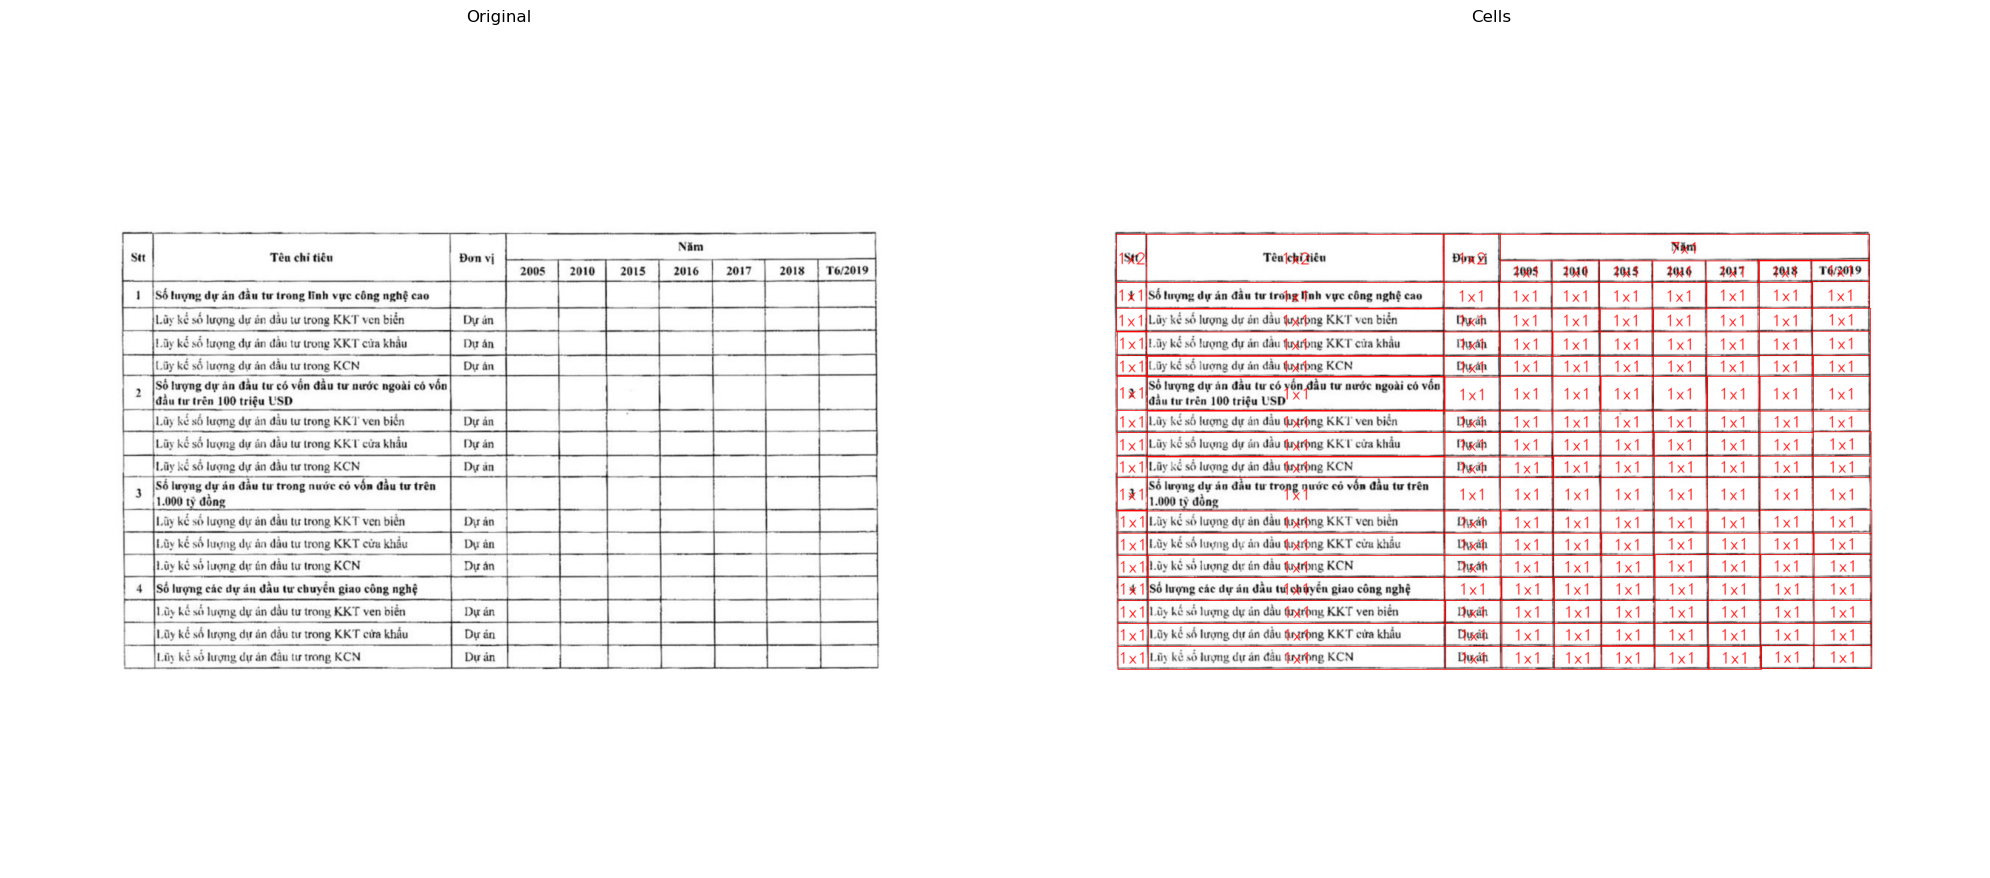

In [47]:
def create_cells(rows, columns):
    cells = []

    for row_index in range(len(rows)-1):
        for top_left_index in range(len(rows[row_index]) - 1):
            top_left = rows[row_index][top_left_index]
            top_right = rows[row_index][top_left_index + 1]
            # Tìm cột của top_left
            top_left_col_index = 0
            for top_left_col_index in range(len(columns)):
                if abs(columns[top_left_col_index][0][0] - top_left[0]) < 10:
                    break
            # duyệt qua cột vừa tìm được và tìm bottom_left
            bottom_left = list(filter(lambda c: c[1] > top_left[1], columns[top_left_col_index]))[0]

             # Tìm cột của top_right
            top_right_col_index = 0
            for top_right_col_index in range(len(columns)):
                if abs(columns[top_right_col_index][0][0] - top_right[0]) < 10:
                    break
            # duyệt qua cột vừa tìm được và tìm bottom_left
            bottom_right = list(filter(lambda c: c[1] > top_right[1], columns[top_right_col_index]))[0]

            # Xử lý bottom_left và bottom_right không cùng 1 hàng
            bottom_right = (bottom_right[0], max(bottom_left[1], bottom_right[1]))
            bottom_left = (bottom_left[0], max(bottom_left[1], bottom_right[1]))
            # print('top_left',top_left,'top_right', top_right, 'bottom_right', bottom_right)

            # Tìm hàng của bottom_right
            bottom_right_row_index = 0
            for bottom_right_row_index in range(len(rows)):
                if abs(rows[bottom_right_row_index][0][1] - bottom_right[1]) < 10:
                    break

            # Tạo bbox
            bbox =  (top_left[0], top_left[1], bottom_right[0], bottom_right[1])
            # print(bbox)
            # tính row_span và col_span của bbox
            row_span = top_right_col_index - top_left_col_index
            col_span = bottom_right_row_index - row_index
            # Tạo cell
            cell = {'bbox': bbox, 'row_span': row_span, 'col_span': col_span}
            cells.append(cell)
            # return cells
    
    return cells

cells = create_cells(rows, columns)

def draw_text_in_center(img, text, box):
    x1, y1, x2, y2 = box

    center = (int((x1 + x2) / 2), int((y1 + y2) / 2))
    text_size, _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 1)
    text_width = text_size[0]
    text_height = text_size[1]
    text_origin = (center[0] - text_width // 2, center[1] + text_height // 2)

    cv2.putText(img, text, text_origin, cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 1, cv2.LINE_AA)

def draw_cells(img, cells):
    img = img.copy()
    for index, cell in enumerate(cells, start=1):
        x1,y1,x2,y2 = cell['bbox']
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 255), 1)
        center = (int((x1 + x2) / 2), int((y1 + y2) / 2))
        draw_text_in_center(img, f"{cell['row_span']}x{cell['col_span']}", cell['bbox'])
        # cv2.circle(img, center, 5, (255, 0, 255), -1)
    return img

cells_img = draw_cells(image_ok, cells)
display_images_with_labels([(image_ok, "Original"), (cells_img, "Cells")], (1, 2), show_axis=False)